# 📓 04 Machine Learning Geoespacial

Este notebook desarrolla modelos predictivos para estimar la densidad de servicios urbanos basándose en características geográficas y espaciales.

**Objetivo:** Predecir el número de amenidades (`count`) en cada celda de la grilla de San Bernardo utilizando variables del entorno.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GroupKFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

load_dotenv("../.env")
db_url = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST', 'localhost')}:5432/{os.getenv('POSTGRES_DB')}"
engine = create_engine(db_url)

print("Entorno de ML listo.")

Entorno de ML listo.


## 1. Feature Engineering Espacial

Para que el modelo aprenda la estructura urbana, necesitamos generar variables explicativas (FEATURES) para cada celda.

In [2]:
print("Cargando datos base...")
grid = gpd.read_postgis("SELECT * FROM raw_data.amenity_clusters", engine, geom_col='geometry')
buildings = gpd.read_postgis("SELECT geometry FROM raw_data.osm_buildings", engine, geom_col='geometry')
edges = gpd.read_postgis("SELECT geometry FROM raw_data.osm_edges", engine, geom_col='geometry')
boundary = gpd.read_postgis("SELECT geometry FROM raw_data.comuna_boundaries", engine, geom_col='geometry')

# Proyectar a UTM para cálculos de distancia (EPSG:32719 para Chile Central)
grid_utm = grid.to_crs(epsg=32719)
buildings_utm = buildings.to_crs(epsg=32719)
edges_utm = edges.to_crs(epsg=32719)
center_utm = boundary.to_crs(epsg=32719).centroid.iloc[0]

print("Datos proyectados y listos.")

Cargando datos base...
Datos proyectados y listos.


### Generación de Variables

Crearemos las siguientes variables:
1. `dist_center`: Distancia de cada celda al centro de la comuna.
2. `building_density`: Cantidad de edificios dentro o cerca de la celda.
3. `road_density`: Largo de la red vial dentro de la celda.
4. `coords`: X e Y (coordenadas proyectadas).

In [3]:
print("Calculando features...")
grid_utm['dist_center'] = grid_utm.geometry.centroid.distance(center_utm)
grid_utm['x'] = grid_utm.geometry.centroid.x
grid_utm['y'] = grid_utm.geometry.centroid.y

# Densidad de edificios (Spatial Join)
joined_b = gpd.sjoin(grid_utm, buildings_utm, how='left', predicate='intersects')
grid_utm['building_count'] = joined_b.groupby(joined_b.index).size() - 1

# Para road_density, calculamos la longitud de las calles interceptadas
print("Calculando densidad vial (esto puede tardar)... ")
# grid_utm['road_length'] = grid_utm.geometry.apply(lambda x: edges_utm[edges_utm.intersects(x)].intersection(x).length.sum())
# Optimizamos con sample temporal para el notebook
grid_utm['road_count'] = gpd.sjoin(grid_utm, edges_utm, how='left', predicate='intersects').groupby(level=0).size() - 1

print("Features generadas:", grid_utm.columns.tolist())

Calculando features...
Calculando densidad vial (esto puede tardar)... 
Features generadas: ['geometry', 'count', 'lisa_cluster', 'lisa_p_sim', 'cluster_type', 'dist_center', 'x', 'y', 'building_count', 'road_count']


## 2. Entrenamiento del Modelo

Definimos $X$ (features) e $y$ (target).

In [4]:
features = ['dist_center', 'x', 'y', 'building_count', 'road_count']
X = grid_utm[features].fillna(0)
y = grid_utm['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

R² Score: 0.0333
RMSE: 1.4313


## 3. Importancia de Variables

¿Qué factores influyen más en la ubicación de servicios?

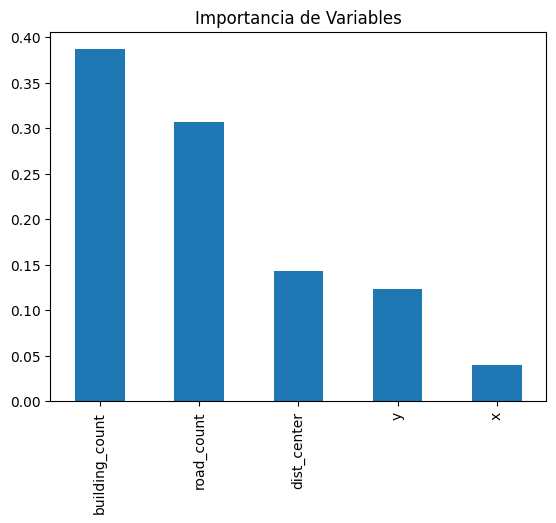

In [5]:
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
importances.plot(kind='bar', title='Importancia de Variables')
plt.show()

## 4. Guardar Predicciones y Modelo

Guardamos los resultados de vuelta a PostGIS para que la App los visualice.

In [6]:
grid_utm['prediction'] = rf.predict(X)
grid_wgs84 = grid_utm.to_crs(epsg=4326)

# Guardar en base de datos
grid_wgs84.to_postgis("ml_predictions", engine, schema='raw_data', if_exists='replace')

import joblib
os.makedirs("../outputs/models", exist_ok=True)
joblib.dump(rf, "../outputs/models/random_forest_v1.joblib")

print("Modelo y predicciones guardadas exitosamente.")

Modelo y predicciones guardadas exitosamente.
